In [1]:
import os 
import sys

import pandas as pd
import xarray as xr

import FINE as fn
from FINE.spagat.RE_representation import represent_RE_technology

cwd = os.getcwd()

%load_ext autoreload
%autoreload 2

C:\Users\k.knosala\Miniconda3\envs\fine-dev-py36\lib\site-packages\ipykernel\parentpoller.py:113: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


# Workflow for spatial aggregation of an energy system model

This example notebook shows how model regions can be merged to obtain fewer regions and also how the number of VRES technologies within each region can be reduced to fewer technology types. 

<img src="spagat_basic_depiction.png" style="width: 1000px;"/>

The figure above dipicts the basic idea behind spatial aggregation. The term spatial grouping refers to grouping (and subsequently merging) of regions that are similar in some sense (NOTE: Please look into the documentation for different methods to group regions). 

Additionally, it is also possible to reduced VRES technologies within each region to a desired number. This process is called spatial representation of VRES technologies. To give you an example, if the results of your PV simulation are spatially detailed or spatially highly resolved, then you could reduce these to a few types within each region. The time series profiles are matched during grouping of these technologies. 


## STEP 1. Set up your ESM instance 

In [2]:
sys.path.append(os.path.join(cwd, '..', 'Multi-regional_Energy_System_Workflow'))
from getData import getData

data = getData()

# 1. Create an energy system model instance
locations = {'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'}
commodityUnitDict = {'electricity': r'GW$_{el}$', 'methane': r'GW$_{CH_{4},LHV}$', 'biogas': r'GW$_{biogas,LHV}$',
                     'CO2': r'Mio. t$_{CO_2}$/h', 'hydrogen': r'GW$_{H_{2},LHV}$'}
commodities = {'electricity', 'hydrogen', 'methane', 'biogas', 'CO2'}

esM = fn.EnergySystemModel(locations=locations, commodities=commodities, numberOfTimeSteps=8760,
                           commodityUnitsDict=commodityUnitDict,
                           hoursPerTimeStep=1, costUnit='1e9 Euro', lengthUnit='km', verboseLogLevel=0)

CO2_reductionTarget = 1


# 2. Add commodity sources to the energy system model

### Wind onshore
esM.add(fn.Source(esM=esM, name='Wind (onshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (onshore), operationRateMax'],
                  capacityMax=data['Wind (onshore), capacityMax'],
                  investPerCapacity=1.1, opexPerCapacity=1.1*0.02, interestRate=0.08,
                  economicLifetime=20))

### PV
esM.add(fn.Source(esM=esM, name='PV', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['PV, operationRateMax'], capacityMax=data['PV, capacityMax'],
                  investPerCapacity=0.65, opexPerCapacity=0.65*0.02, interestRate=0.08,
                  economicLifetime=25))


# 3. Add conversion components to the energy system model

### New combined cycly gas turbines for hydrogen
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (hydrogen)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True,
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### Electrolyzers
esM.add(fn.Conversion(esM=esM, name='Electroylzers', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.7},
                      hasCapacityVariable=True,
                      investPerCapacity=0.5, opexPerCapacity=0.5*0.025, interestRate=0.08,
                      economicLifetime=10))


# 4. Add commodity storages to the energy system model

### Lithium ion batteries
esM.add(fn.Storage(esM=esM, name='Li-ion batteries', commodity='electricity',
                   hasCapacityVariable=True, chargeEfficiency=0.95,
                   cyclicLifetime=10000, dischargeEfficiency=0.95, selfDischarge=1-(1-0.03)**(1/(30*24)),
                   chargeRate=1, dischargeRate=1, doPreciseTsaModeling=False,
                   investPerCapacity=0.151, opexPerCapacity=0.002, interestRate=0.08,
                   economicLifetime=22))

### Hydrogen filled salt caverns
esM.add(fn.Storage(esM=esM, name='Salt caverns (hydrogen)', commodity='hydrogen',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=133,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (hydrogen), capacityMax'],
                   investPerCapacity=0.00011, opexPerCapacity=0.00057, interestRate=0.08,
                   economicLifetime=30))


# 5. Add commodity transmission components to the energy system model

### AC cables
esM.add(fn.LinearOptimalPowerFlow(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix'],
                                  reactances=data['AC cables, reactances']))

### DC cables
esM.add(fn.Transmission(esM=esM, name='DC cables', commodity='electricity', losses=data['DC cables, losses'],
                        distances=data['DC cables, distances'],
                        hasCapacityVariable=True, capacityFix=data['DC cables, capacityFix']))


### Hydrogen pipelines
esM.add(fn.Transmission(esM=esM, name='Pipelines (hydrogen)', commodity='hydrogen',
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=False, bigM=300,
                        locationalEligibility=data['Pipelines, eligibility'],
                        capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                        investPerCapacity=0.000177, investIfBuilt=0.00033,
                        interestRate=0.08, economicLifetime=40))

# 6. Add commodity sinks to the energy system model

### Electricity demand
esM.add(fn.Sink(esM=esM, name='Electricity demand', commodity='electricity',
                hasCapacityVariable=False, operationRateFix=data['Electricity demand, operationRateFix']))

## 7.2. Hydrogen sinks
FCEV_penetration=0.5
esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                operationRateFix=data['Hydrogen demand, operationRateFix']*FCEV_penetration))

The distances of a component are set to a normalized value of 1.


 c:\users\k.knosala\tools\fine\FINE\utils.py:669: UserWarning:A declaration of bigM is not necessary if hasIsBuiltBinaryVariable is set to false. The value of bigM will be ignored in the optimization.


## STEP 2. Spatial grouping of regions

In [3]:
# The input data to spatial grouping are esM instance and the shapefile containing model regions' geometries
SHAPEFILE_PATH = os.path.join(cwd, '..', 'Multi-regional_Energy_System_Workflow/InputData/SpatialData/ShapeFiles/clusteredRegions.shp')

In [4]:
# Once the regions are grouped, the data witin each region group needs to be aggregated. Through the aggregation_function_dict
# parameter, it is possible to define how each variable show be aggregated. Please refer to the documentation for more 
# information. 

aggregation_function_dict = {'operationRateMax': ('mean', None),
                             'operationRateFix': ('sum', None),
                             'locationalEligibility': ('bool', None),
                             'capacityMax': ('sum', None),
                             'investPerCapacity': ('sum', None),
                             'investIfBuilt': ('sum', None),
                             'opexPerOperation': ('sum', None),
                             'opexPerCapacity': ('sum', None),
                             'opexIfBuilt': ('sum', None),
                             'interestRate': ('mean', None),
                             'economicLifetime': ('mean', None),
                             'capacityFix': ('sum', None),
                             'losses': ('mean', None),
                             'distances': ('mean', None),
                             'commodityCost': ('mean', None),
                             'commodityRevenue': ('mean', None),
                             'opexPerChargeOperation': ('mean', None),
                             'opexPerDischargeOperation': ('mean', None),
                             'QPcostScale': ('sum', None), 
                              'technicalLifetime': ('sum', None)}

In [5]:
# You can provide a path to save the grouping results with desired file names. Two files are saved - a shapefile containing
# the merged region geometries and a netcdf file containing the aggregated esM instance data. 
sds_region_filename='aggregated_regions'
sds_xr_dataset_filename='aggregated_xr_ds.nc4'

In [6]:
# Spatial grouping 
aggregated_esM = esM.aggregateSpatially(shapefile=SHAPEFILE_PATH, 
                                       grouping_mode='parameter_based', 
                                       nRegionsForRepresentation=6,
                                       aggregatedResultsPath=os.path.join(cwd, 'output_data'), 
                                       aggregation_function_dict=aggregation_function_dict,
                                       sds_region_filename=sds_region_filename,
                                       sds_xr_dataset_filename=sds_xr_dataset_filename)

# NOTE: The UserWarnings basically say that constant variables (variables that remain the same across all regions) and 
# geometry related varialbes are not considered for spatial grouping. 

 c:\users\k.knosala\tools\fine\FINE\IOManagement\utilsIO.py:70: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\k.knosala\tools\fine\FINE\IOManagement\utilsIO.py:70: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\k.knosala\tools\fine\FINE\IOManagement\utilsIO.py:70: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\k.knosala\tools\fine\FINE\IOManagement\utilsIO.py:70: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\k.knosala\tools\fine\FINE\IOManagement\utilsIO.py:37: UserWarning:More than one _ foun

elapsed time for perform_parameter_based_grouping: 0.05 minutes


 c:\users\k.knosala\tools\fine\FINE\spagat\representation.py:52: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
 c:\users\k.knosala\tools\fine\FINE\IOManagement\utilsIO.py:70: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\k.knosala\tools\fine\FINE\IOManagement\utilsIO.py:70: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\k.knosala\tools\fine\FINE\IOManagement\utilsIO.py:70: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

 c:\users\k.knosala\tools\fine\FINE\IOManagement\standardIO.py:695: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\k.knosala\tools\fine\FINE\IOManagement\standardIO.py:695: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\k.knosala\tools\fine\FINE\IOManagement\standardIO.py:695: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\k.knosala\tools\fine\FINE\IOManagement\standardIO.py:695: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\k.knosala\tools\fine\F

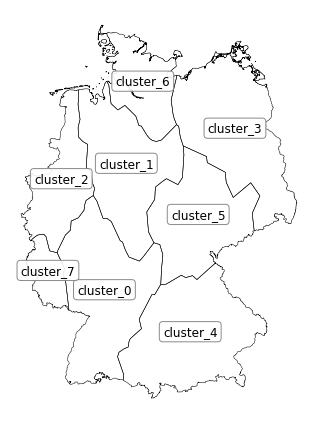

In [7]:
# Original spatial resolution
fig, ax = fn.plotLocations(SHAPEFILE_PATH, plotLocNames=True, indexColumn='index')

In [8]:
# Spatial resolution after aggregation
AGGREGATED_SHP_PATH = os.path.join(cwd, 'output_data', f'{sds_region_filename}.shp')

 c:\users\k.knosala\tools\fine\FINE\IOManagement\standardIO.py:695: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\k.knosala\tools\fine\FINE\IOManagement\standardIO.py:695: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\k.knosala\tools\fine\FINE\IOManagement\standardIO.py:695: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\k.knosala\tools\fine\FINE\IOManagement\standardIO.py:695: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\k.knosala\tools\fine\F

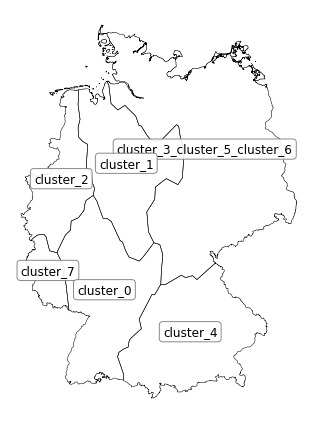

In [13]:
fig, ax = fn.plotLocations(AGGREGATED_SHP_PATH, plotLocNames=True, indexColumn='id')

In [14]:
# The locations in the resulting esM instance are now 6.
new_locations = list(aggregated_esM.locations)
new_locations

['cluster_7',
 'cluster_0',
 'cluster_2',
 'cluster_4',
 'cluster_3_cluster_5_cluster_6',
 'cluster_1']

In [15]:
#  And corresponding data has also been aggregated
aggregated_esM.getComponentAttribute('Wind (onshore)', 'operationRateMax')

space,cluster_0,cluster_1,cluster_2,cluster_3_cluster_5_cluster_6,cluster_4,cluster_7
time,,,,,,
0,0.569672,0.984958,0.987930,0.866467,0.276660,0.623974
1,0.582094,0.972450,0.976257,0.861652,0.275148,0.667338
2,0.608804,0.951505,0.936413,0.849960,0.286690,0.696272
3,0.637364,0.913621,0.887258,0.830391,0.303492,0.705269
4,0.659234,0.874988,0.822736,0.807255,0.324501,0.710336
...,...,...,...,...,...,...
8755,0.313734,0.673692,0.757970,0.463022,0.155183,0.426975
8756,0.279877,0.642817,0.740666,0.418830,0.119844,0.429161
8757,0.270794,0.589719,0.789207,0.380105,0.101342,0.507018


# STEP 3. Spatial Representation of VRES (Optional)

### STEP 3a. Spatial representation

In [16]:
# The input data to spatial representation are a netcdf file containing highly resolved VRES data 
# and the shapefile containing model regions' geometries

# Here, both PV and wind turbines are represented 

ONSHORE_WIND_DATA_PATH = os.path.join(cwd, 'input_RE_representation_data', 'DEU_wind.nc4')
PV_DATA_PATH = os.path.join(cwd, 'input_RE_representation_data', 'DEU_PV.nc4')

In [17]:
# Let us first take a look at one of these datasets 

xr.open_dataset(ONSHORE_WIND_DATA_PATH)

<xarray.Dataset>
Dimensions:      (time: 8760, x: 88, y: 117)
Coordinates:
  * y            (y) float64 2.832e+06 2.838e+06 ... 3.408e+06 3.412e+06
  * x            (x) float64 4.092e+06 4.098e+06 ... 4.522e+06 4.528e+06
    spatial_ref  int32 ...
  * time         (time) datetime64[ns] 2015-01-01 ... 2015-12-31T23:00:00
Data variables:
    capacity     (y, x) float64 ...
    capfac       (time, y, x) float32 ...
Attributes:
    xy_reference_system:  EPSG:3035
    grid_mapping:         spatial_ref

In [19]:
## Representation 
represented_wind_ds = represent_RE_technology(ONSHORE_WIND_DATA_PATH, 
                                            'xy_reference_system',
                                            AGGREGATED_SHP_PATH,
                                            n_timeSeries_perRegion=5,
                                            capacity_var_name='capacity',
                                            capfac_var_name='capfac',
                                            index_col = 'id')

represented_pv_ds = represent_RE_technology(PV_DATA_PATH, 
                                            'xy_reference_system',
                                            AGGREGATED_SHP_PATH,
                                            n_timeSeries_perRegion=5,
                                            capacity_var_name='capacity',
                                            capfac_var_name='capfac',
                                            index_col = 'id')

elapsed time for represent_RE_technology: 2.24 minutes
elapsed time for represent_RE_technology: 2.37 minutes


In [20]:
represented_wind_ds

<xarray.Dataset>
Dimensions:     (TS_ids: 5, region_ids: 6, time: 8760)
Coordinates:
  * region_ids  (region_ids) object 'cluster_3_cluster_5_cluster_6' ... 'clus...
  * TS_ids      (TS_ids) <U4 'TS_0' 'TS_1' 'TS_2' 'TS_3' 'TS_4'
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T23:00:00
Data variables:
    capacity    (region_ids, TS_ids) float64 4.773e+07 2.296e+04 ... 2.745e+04
    capfac      (time, region_ids, TS_ids) float64 0.4944 0.4 ... 0.3799 0.76

In [21]:
represented_pv_ds

<xarray.Dataset>
Dimensions:     (TS_ids: 5, region_ids: 6, time: 8760)
Coordinates:
  * region_ids  (region_ids) object 'cluster_3_cluster_5_cluster_6' ... 'clus...
  * TS_ids      (TS_ids) <U4 'TS_0' 'TS_1' 'TS_2' 'TS_3' 'TS_4'
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T23:00:00
Data variables:
    capacity    (region_ids, TS_ids) float64 4.766e+07 4.59e+04 ... 1.098e+04
    capfac      (time, region_ids, TS_ids) float64 0.1975 0.3 0.2553 ... 0.2 0.1

### STEP 3a. Adding the results to esM instance 

In [22]:
# Now we need to delete 'Wind (onshore)' and 'PV' compoents from aggregated_esM 
# and add the represented results 

In [23]:
## But first we need certain info corresponding to these techs as they remain the same:
wind_investPerCapacity = aggregated_esM.getComponentAttribute('Wind (onshore)', 'investPerCapacity').mean()
wind_opexPerCapacity = aggregated_esM.getComponentAttribute('Wind (onshore)', 'opexPerCapacity').mean()
wind_interestRate = aggregated_esM.getComponentAttribute('Wind (onshore)', 'interestRate').mean()
wind_economicLifetime = aggregated_esM.getComponentAttribute('Wind (onshore)', 'economicLifetime').mean()

pv_investPerCapacity = aggregated_esM.getComponentAttribute('PV', 'investPerCapacity').mean()
pv_opexPerCapacity = aggregated_esM.getComponentAttribute('PV', 'opexPerCapacity').mean()
pv_interestRate = aggregated_esM.getComponentAttribute('PV', 'interestRate').mean()
pv_economicLifetime = aggregated_esM.getComponentAttribute('PV', 'economicLifetime').mean()

In [24]:
## And now we delete them
aggregated_esM.removeComponent('Wind (onshore)')
aggregated_esM.removeComponent('PV')

In [25]:
aggregated_esM.componentModelingDict['SourceSinkModel'].componentsDict

{'Electricity demand': <FINE.sourceSink.Sink at 0x1f1cd24f438>,
 'Hydrogen demand': <FINE.sourceSink.Sink at 0x1f1cd24fac8>}

In [26]:
## Prepare the representation results and add them to aggregated_esM
data = {}   

time_steps = aggregated_esM.totalTimeSteps
regions = represented_wind_ds['region_ids'].values
clusters = represented_wind_ds['TS_ids'].values # technology types per region


for i, cluster in enumerate(clusters):
    # Add a wind turbine
    data.update({f'Wind (onshore), capacityMax {i}': pd.Series(represented_wind_ds.capacity.loc[:,cluster], index=regions)})

    data.update({f'Wind (onshore), operationRateMax {i}': pd.DataFrame(represented_wind_ds.capfac.loc[:,:,cluster].values,
                                                                       index=time_steps, columns=regions)})
    

    # Add a pv
    data.update({f'PV, capacityMax {i}': pd.Series(represented_pv_ds.capacity.loc[:,cluster], index=regions)})

    data.update({f'PV, operationRateMax {i}': pd.DataFrame(represented_pv_ds.capfac.loc[:,:,cluster].values,
                                                                       index=time_steps, columns=regions)})

In [27]:
## add the data 
for i, cluster in enumerate(clusters):
    aggregated_esM.add(fn.Source(esM=aggregated_esM, 
                      name=f'Wind (onshore) {i}',
                      commodity='electricity', 
                      hasCapacityVariable=True,
                      operationRateMax=data[f'Wind (onshore), operationRateMax {i}'],
                      capacityMax=data[f'Wind (onshore), capacityMax {i}'],
                      investPerCapacity=wind_investPerCapacity, 
                      opexPerCapacity=wind_opexPerCapacity,
                      interestRate=pv_interestRate,
                      economicLifetime=wind_economicLifetime
                      ))
    
    aggregated_esM.add(fn.Source(esM=aggregated_esM, 
                      name=f'PV {i}', 
                      commodity='electricity',
                      hasCapacityVariable=True,
                      operationRateMax=data[f'PV, operationRateMax {i}'], 
                      capacityMax=data[f'PV, capacityMax {i}'],
                      investPerCapacity=pv_investPerCapacity, 
                      opexPerCapacity=pv_opexPerCapacity, 
                      interestRate=pv_interestRate,
                      economicLifetime=pv_economicLifetime))

In [28]:
aggregated_esM.componentModelingDict['SourceSinkModel'].componentsDict

{'Electricity demand': <FINE.sourceSink.Sink at 0x1f1cd24f438>,
 'Hydrogen demand': <FINE.sourceSink.Sink at 0x1f1cd24fac8>,
 'Wind (onshore) 0': <FINE.sourceSink.Source at 0x1f1cd213518>,
 'PV 0': <FINE.sourceSink.Source at 0x1f1d00f84a8>,
 'Wind (onshore) 1': <FINE.sourceSink.Source at 0x1f1d00f8d68>,
 'PV 1': <FINE.sourceSink.Source at 0x1f1d00eb710>,
 'Wind (onshore) 2': <FINE.sourceSink.Source at 0x1f1d8d4e0f0>,
 'PV 2': <FINE.sourceSink.Source at 0x1f1d8d4ea58>,
 'Wind (onshore) 3': <FINE.sourceSink.Source at 0x1f1cd004438>,
 'PV 3': <FINE.sourceSink.Source at 0x1f1cd004da0>,
 'Wind (onshore) 4': <FINE.sourceSink.Source at 0x1f1ccff6780>,
 'PV 4': <FINE.sourceSink.Source at 0x1f1cd04e128>}

# Step 4. Temporal Aggregation

Although spatial aggregation aids in reducing the computational complexity of optimization, temporal aggregation is still necessary. 

Spatial aggregation is not here is replace temporal aggregation. They both go hand-in-hand. 

Imagine performing temporal aggregation on a model with too many regions and too many VRES technologies per region. You have to reduce the temporal resolution to a large extent. Or you can take too few regions and 1 time series per VRES technology, per region and reduce the temporal resolution to a smaller extent. 

With spatial and temporal aggregation, you need not compromise on either the temporal or spatial resolution of your model. 

In [29]:
aggregated_esM.aggregateTemporally(numberOfTypicalPeriods=7)


Clustering time series data with 7 typical periods and 24 time steps per period...


 C:\Users\k.knosala\Miniconda3\envs\fine-dev-py36\lib\site-packages\tsam\timeseriesaggregation.py:831: UserWarning:Max iteration number reached for "PV 2_operationRate_cluster_4" while rescaling the cluster periods. The integral of the aggregated time series deviates by: 0.0%
 C:\Users\k.knosala\Miniconda3\envs\fine-dev-py36\lib\site-packages\tsam\timeseriesaggregation.py:831: UserWarning:Max iteration number reached for "PV 2_operationRate_cluster_7" while rescaling the cluster periods. The integral of the aggregated time series deviates by: 0.0%
 C:\Users\k.knosala\Miniconda3\envs\fine-dev-py36\lib\site-packages\tsam\timeseriesaggregation.py:831: UserWarning:Max iteration number reached for "PV 3_operationRate_cluster_0" while rescaling the cluster periods. The integral of the aggregated time series deviates by: 0.0%
 C:\Users\k.knosala\Miniconda3\envs\fine-dev-py36\lib\site-packages\tsam\timeseriesaggregation.py:831: UserWarning:Max iteration number reached for "PV 3_operationRate_c

		(4.0250 sec)



 C:\Users\k.knosala\Miniconda3\envs\fine-dev-py36\lib\site-packages\tsam\timeseriesaggregation.py:984: UserWarning:Something went wrong: At least one minimal value of the aggregated time series exceeds the minimal value the input time series


# Step 5. Optimization

In [30]:
aggregated_esM.optimize(timeSeriesAggregation=True, 
                        optimizationSpecs='OptimalityTol=1e-3 method=2 cuts=0')

Time series aggregation specifications:
Number of typical periods:7, number of time steps per period:24

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0630 sec)

Declaring sets, variables and constraints for LOPFModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.3276 sec)

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.9899 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.8425 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.1488 sec)

Declaring shared potential constraint...
		(0.0020 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances.